In [2]:
import seaborn as sns
import pandas as pd
from libpysal import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

In [3]:
infile_path = "../data/week13data/ACS_10_5YR_County.shp" #your path will be different
db = gpd.read_file(infile_path) # this is a large file, it may take some time to read

In [4]:
db.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,...,DP3_HC_239,DP3_HC_240,DP3_HC_241,DP3_HC_242,DP3_HC_243,DP3_HC_244,DP3_HC_245,Shape_Leng,Shape_Area,geometry
0,02,013,01419964,02013,Aleutians East,Aleutians East Borough,04,H1,G4020,NaN,...,16,9.7,6.6,6415,2359,(X),(X),31.272921,5.487726,"MULTIPOLYGON (((-162.63769 54.80112, -162.6411..."
1,02,016,01419965,02016,Aleutians West,Aleutians West Census Area,05,H5,G4020,NaN,...,39,17.7,5.2,21377,4830,(X),(X),53.175472,4.858873,"MULTIPOLYGON (((177.44593 52.11133, 177.44302 ..."
2,28,107,00695776,28107,Panola,Panola County,06,H1,G4020,NaN,...,236,16.4,2.0,13161,1817,(X),(X),1.733565,0.178973,"POLYGON ((-90.13476 34.22603, -90.13476 34.226..."
3,28,101,00695773,28101,Newton,Newton County,06,H1,G4020,NaN,...,184,18.3,2.4,14613,2273,(X),(X),1.523373,0.143887,"POLYGON ((-89.13497 32.57697, -89.13466 32.576..."
4,28,027,00695738,28027,Coahoma,Coahoma County,06,H1,G4020,NaN,...,204,14.0,2.1,14109,2097,(X),(X),2.517210,0.147780,"POLYGON ((-90.59062 33.98690, -90.59473 33.986..."


In [5]:
# Index table on the GEOID
db = db.set_index("GEOID10", drop=False)

# Display summary
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3221 entries, 02013 to 27169
Columns: 305 entries, STATEFP10 to geometry
dtypes: float64(100), geometry(1), int64(144), object(60)
memory usage: 7.6+ MB


In [6]:
db.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [8]:
# What's the correct projection for this purpose???
db = db.to_crs(epsg=6269)
# use NAD 1983 Equidistant Conic North America... the equidistant part is the important part


<Axes: >

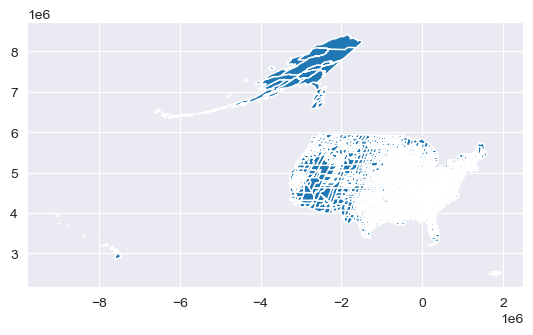

In [9]:
db.plot()

In [10]:
# we'll be working with median income... what's the code?
# DP3_HC01_VC85

# check it
db['DP3_HC01_VC85'] 

# didn't work... why???

KeyError: 'DP3_HC01_VC85'

In [ ]:
# shapefile attribute names can be a max of 10 characters long 
# (see https://pro.arcgis.com/en/pro-app/latest/tool-reference/tool-errors-and-warnings/001001-010000/tool-errors-and-warnings-00126-00150-000142.htm)

# lol at the ESRI "solution" (below)
### Problem description: Field names for shapefiles and dBASE tables can be no more than 10 characters in length.
### Solution: Shorten the field name to 10 or fewer characters.

# the sad reality of working with real-world data

# So how can we find the correct attribute???


In [11]:
db['DP3_HC_214']

GEOID10
02013    54375
02016    72917
28107    34030
28101    36154
28027    24726
         ...  
37077    48210
37111    34953
27021    42445
27057    45066
27169    44217
Name: DP3_HC_214, Length: 3221, dtype: int64

In [12]:
# setup our W, takes some time
w = weights.Queen.from_dataframe(db, idVariable="GEOID10")

# other options
#w = weights.KNN.from_dataframe(db, k=5) # KNN option
#w = weights.DistanceBand.from_dataframe(db, 1000, binary=False) #IDW with a cutoff... be careful about units

/var/folders/wc/y8x0lwys7d7c8tfp4kpwxy8w0000gn/T/ipykernel_37089/1215278180.py:2: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(db, idVariable="GEOID10")
/Users/pjbitterman/opt/anaconda3/envs/fixed_hopefully/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 15003, 15001, 15007.
  warnings.warn(message)


(2500000.0, 3500000.0)

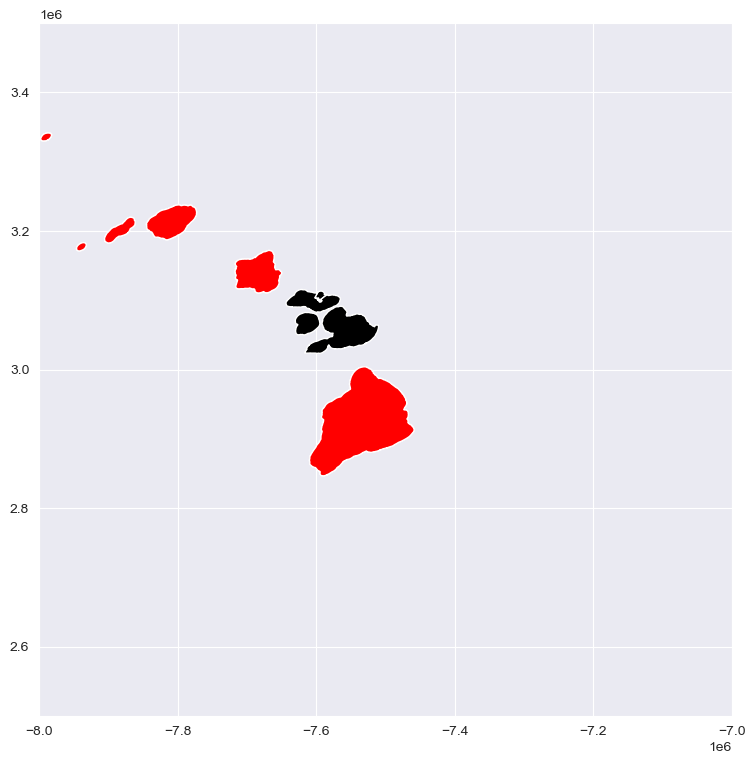

In [17]:
# islands warning

ax = db.plot(color='k', figsize=(9, 9))
db.loc[w.islands, :].plot(color='red', ax=ax);
ax.set_xlim(-8e6, -7e6) # Zoom in a bit
ax.set_ylim(2.5e6, 3.5e6)
# hard to see, so zoom in. The islands are literally the islands in hawaii

<Axes: >

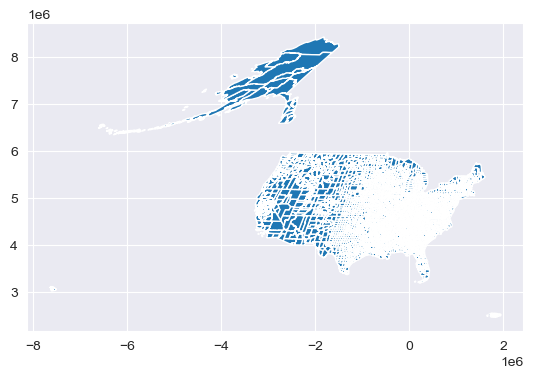

In [18]:
# islands will screw up the analysis, so drop them
db = db.drop(w.islands)

db.plot() # no hawaii :(

In [19]:
# need to recreate the W with the islands missing
# takes some time
w = weights.Queen.from_dataframe(db, idVariable="GEOID10")

/var/folders/wc/y8x0lwys7d7c8tfp4kpwxy8w0000gn/T/ipykernel_37089/521856941.py:3: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(db, idVariable="GEOID10")
/Users/pjbitterman/opt/anaconda3/envs/fixed_hopefully/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


In [20]:
#row standardize it
w.transform  = 'R'

In [21]:
# make the column names easier to remember/work with:
db['income'] = db['DP3_HC_214']

db['w_income'] = weights.lag_spatial(w, db['income'])

In [22]:
# For some of the techniques we will be seeing below, 
# it makes more sense to operate with the standardized version of a variable, 
# rather than with the raw one. 

# In this case, we'll calculate a z-score for each variable,
# meaning we will subtract the average value and
# divide by the standard deviation each observation of the column. 
# This can be done easily with a bit of basic algebra in Python:

db['income_std'] = (db['income'] - db['income'].mean()) / db['income'].std()

# then recalculate the standardized lag
db['w_income_std'] = weights.lag_spatial(w, db['income_std'])

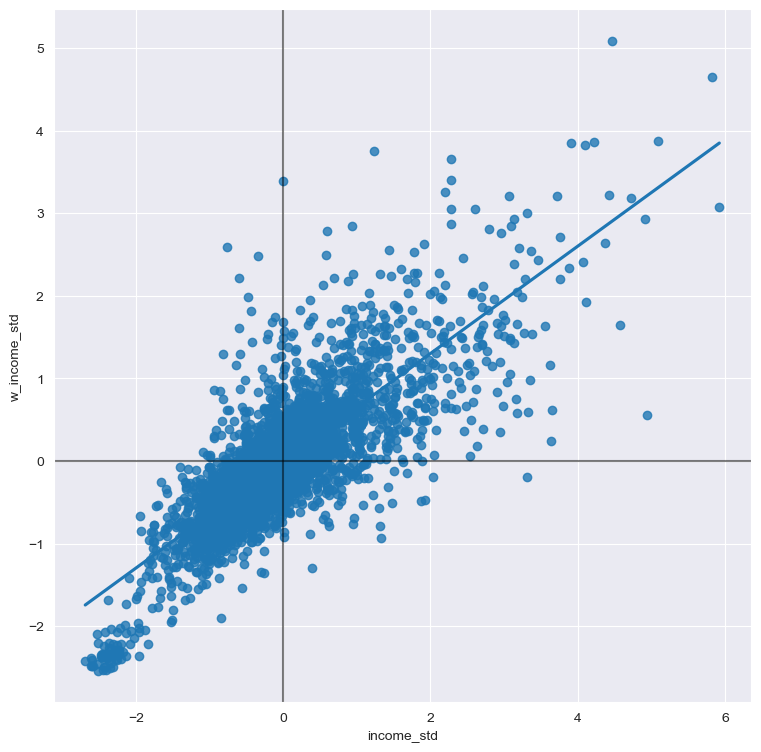

In [23]:
# make a moran plot by hand

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='income_std', y='w_income_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [24]:
# calculating Moran's I

mi = esda.Moran(db['income'], w)

In [25]:
mi #oops, it's an object

In [26]:
mi.I

0.6495803951818576

In [27]:
# show it's the same with the standardized values
mi_std = esda.Moran(db['income_std'], w)
mi_std.I

0.6495803951818575

In [28]:
# check for significance:

mi.p_sim # what does a p-value mean?

0.001

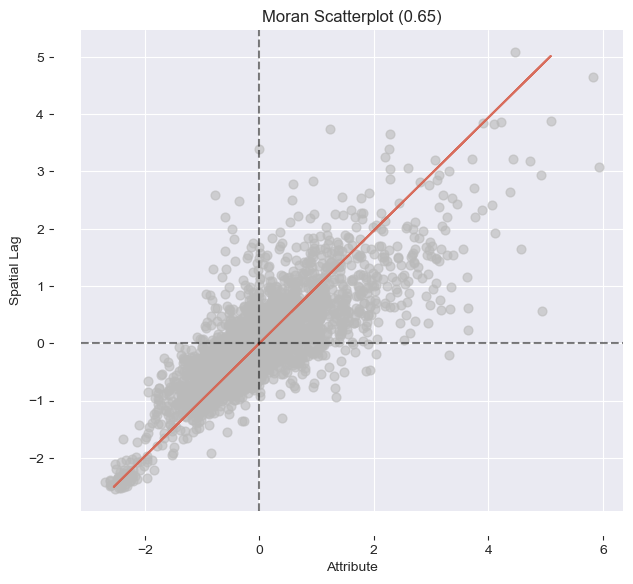

In [29]:
# splot has some handy functions:
moran_scatterplot(mi);

In [30]:
# LOCAL SPATIAL AUTOCORRELATION BELOW

In [31]:
# Moran’s I can tell us values are clustered overall, 
# but it will not inform us about where the clusters are. 
# We need local measure of spatial autocorrelation. 
# Local measures consider each single observation in a dataset and operate on them, 
# as opposed to on the overall data, as global measures do.

# Because of that, they are *not* good a summarizing a map, but they allow to obtain further insight.

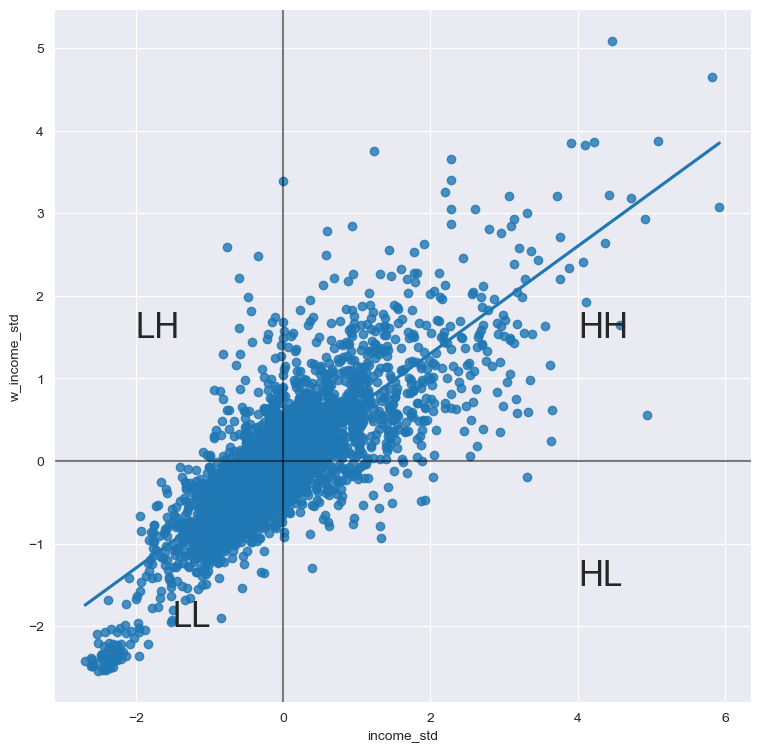

In [32]:
## Moran plot with quadrant labels (for fun)

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='income_std', y='w_income_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(4.0, 1.5, "HH", fontsize=25)
plt.text(4.0, -1.5, "HL", fontsize=25)
plt.text(-2, 1.5, "LH", fontsize=25)
plt.text(-1.5, -2, "LL", fontsize=25)
# Display
plt.show()

In [33]:
### LISAs: Local Indicators of Spatial Autocorrelation

# Main idea: identify cases in which the comparison between 
# the value of an observation and the average of its neighbors 
# is either more similar (HH, LL) or dissimilar (HL, LH) 
# than we would expect from pure chance. 

# Similar to the one in the global Moran’s I, 
# but applied to each observation, resulting then in as many statistics as original observations.

In [34]:
lisa = esda.Moran_Local(db['income_std'], w)

In [35]:
# Not super useful to look at numerical result of LISAs
# B/c there's a statistic for every observation in the data, so 
# it is difficult to extract any meaningful pattern
# So we map the data, extracting...
# the significant observations (those that are highly unlikely to have come from pure chance) 
# and plot them with a specific color depending on their quadrant category



In [36]:
# Break observations into significant or not at p = 0.05
db['significant'] = lisa.p_sim < 0.05

# Store the quadrant they belong to
db['quadrant'] = lisa.q

In [37]:
### What are the types of of the data in the columns we just created?

In [38]:
db['significant'].head()

GEOID10
02013    False
02016    False
28107     True
28101     True
28027     True
Name: significant, dtype: bool

In [39]:
# check the p-values directly
lisa.p_sim[:5]

array([0.074, 0.139, 0.004, 0.002, 0.001])

In [40]:
db['quadrant'].head()

# 1: HH
# 2: LH
# 3: LL
# 4: HL

GEOID10
02013    1
02016    1
28107    3
28101    3
28027    3
Name: quadrant, dtype: int64

(<Figure size 640x480 with 1 Axes>, <Axes: >)

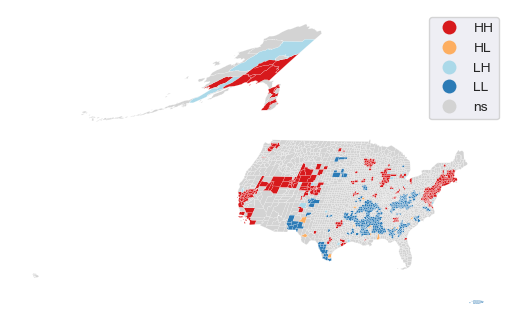

In [41]:
# quick map with splot
lisa_cluster(lisa, db)

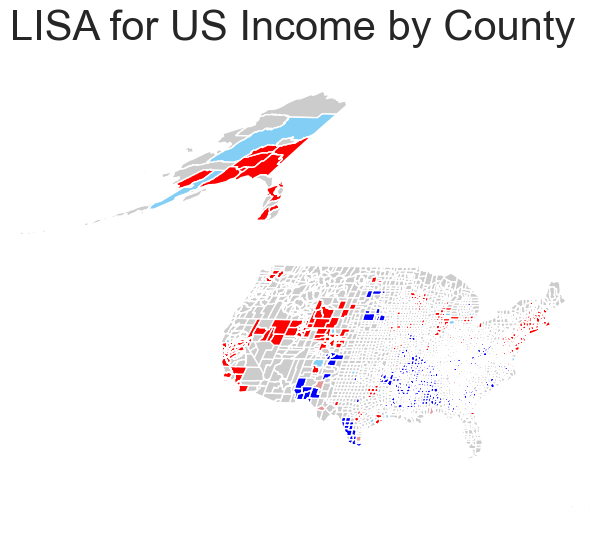

In [45]:
# if we want more control, we can explicitly construct the map on our own:

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 6))
# Plot insignificant clusters
ns = db.loc[db['significant']==False, 'geometry']
ns.plot(ax=ax, color='0.8') # a shade of gray
# Plot HH clusters
hh = db.loc[(db['quadrant']==1) & (db['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = db.loc[(db['quadrant']==3) & (db['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = db.loc[(db['quadrant']==2) & (db['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = db.loc[(db['quadrant']==4) & (db['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for US Income by County', size=30)
f.set_facecolor('white')
ax.set_axis_off()
ax.set_xlim(-6.2e6, 2e6)
plt.show()

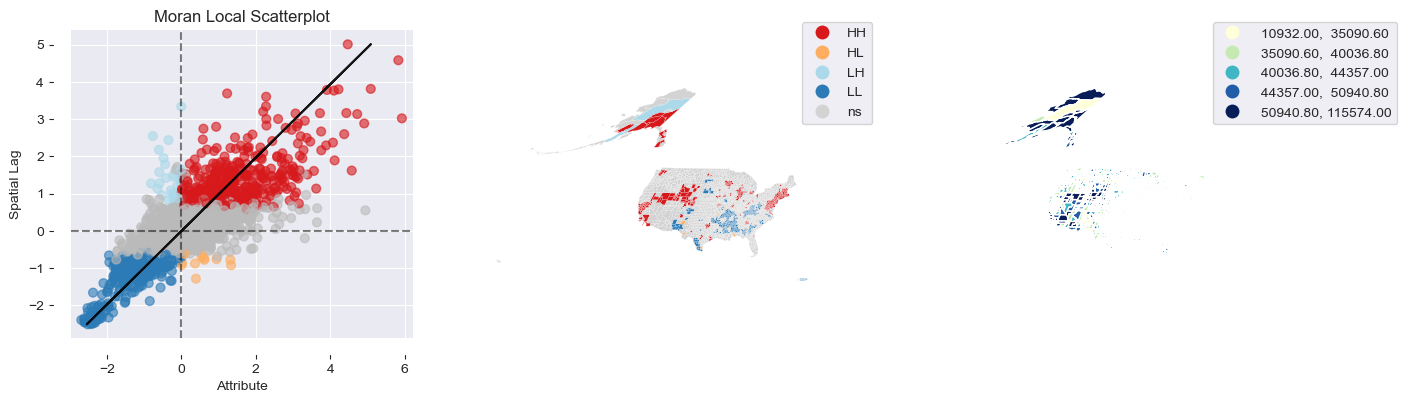

In [46]:
# more functions that are baked-in to splot
plot_local_autocorrelation(lisa, db, 'income');

In [38]:
### YOUR TASK (also for lab),

# Do the above again, but:
# 1. With a different type of weights matrix
# 2. With a subset of the US, with AT MINIMUM 4 states, MAXIMUM 7 states
# 3. Use another variable (yes, you'll have to figure out which is which - think about how)
# 3.hint: I started w/the *Counties* geodatabase from: https://www.census.gov/geographies/mapping-files/2010/geo/tiger-data.html
# 4. Interpret your results (questions forthcoming)